# Test 1 -  Common Test I. Multi-Class Classification

**Author:** [Thanveer ahamed](developer.thanveer@gmail.com | https://github.com/Thanveerahmd)<br>
**Date created:** 2023/03/30<br>
**Description:** Build a model for classifying the images into lenses. i developed a model called LensNet "LensNet", is a deep learning model for image classification, built using the TensorFlow and Keras libraries. The purpose of this model is to classify grascale lens images into different categories based on the input data. The uniqueness of this model lies in its architecture, which consists of data augmentation, initial convolution block, ResNet-style convolutional blocks, fully connected layers, and a classifier.

# Imports

In [ ]:
import os
import pdb
import warnings
import itertools
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras
from keras import layers
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from keras.layers import Layer, Input, Add, Flatten,Dense, MultiHeadAttention, Embedding,LayerNormalization, Dropout, LeakyReLU,RandomFlip, RandomRotation, RandomZoom
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Data Loading

In [3]:
## Set random seed for reproducibility ###
SEED = 1
keras.utils.set_random_seed(SEED)

In [4]:
DATAPATH = './dataset'
OUTPATH = './output' # Storing output
os.makedirs(OUTPATH, exist_ok=True)
SAVEPATH = os.path.join(OUTPATH, 'weights') # For storing model weights
os.makedirs(SAVEPATH)
CKP_PATH = os.path.join(SAVEPATH, 'ckp')

CATEGORIES = ('no', 'sphere', 'vort') # Labels: no=0, sphere=1, vort=2

In [5]:
def load_data(root, datatype, categories, use_cached=True):
    if use_cached:
        try:
            x = np.load(os.path.join(root, f'X_{datatype}.npy'))
            y = np.load(os.path.join(root, f'Y_{datatype}.npy'))
            return x, y
        except FileNotFoundError as _:
            warnings.warn('Cached data does not exist! Loading from raw data.')

    x, y = [], []
    num_classes = len(categories)
    for index, category in enumerate(categories):
        category_path = os.path.join(root, datatype, category)
        for filename in os.scandir(category_path):
            # Load data
            filedata = np.load(filename.path)
            x.append(filedata)

            # Load label (Convert into onehot)
            label = np.stack([np.eye(num_classes)[index]
                              for _ in range(len(filedata))], axis=0)
            y.append(label)
    x = np.expand_dims(np.concatenate(x, axis=0), axis=-1) # add channel axis
    y = np.concatenate(y, axis=0)

    # Save
    np.save(os.path.join(root, f'X_{datatype}.npy'), x)
    np.save(os.path.join(root, f'Y_{datatype}.npy'), y)

    return x, y

In [6]:
X_TRAIN, Y_TRAIN = load_data(DATAPATH, 'train', CATEGORIES, use_cached=True)
print(f'Shape of X_TRAIN: {X_TRAIN.shape}')
print(f'Shape of Y_TRAIN: {Y_TRAIN.shape}')

X_TEST, Y_TEST = load_data(DATAPATH, 'test', CATEGORIES, use_cached=True)
print(f'Shape of X_TEST: {X_TEST.shape}')
print(f'Shape of Y_TEST: {Y_TEST.shape}')

C:\Users\Thanveer\AppData\Local\Temp/ipykernel_12824/3736218854.py:8: UserWarning: Cached data does not exist! Loading from raw data.
  warnings.warn('Cached data does not exist! Loading from raw data.')


Shape of X_TRAIN: (30000, 150, 150, 1)
Shape of Y_TRAIN: (30000, 3)
Shape of X_TEST: (7500, 150, 150, 1)
Shape of Y_TEST: (7500, 3)


In [9]:
X_TRAIN, X_VAL, Y_TRAIN, Y_VAL = train_test_split(X_TRAIN, Y_TRAIN, test_size=0.1)

# Data pre-processing 

In [11]:
def standardize(x, datatype, root):
    '''Standardize image examples'''
    # Make image contrast similar across all images
    x = x - np.mean(x, axis=(1, 2), keepdims=True)
  
    if datatype == 'train':
        # Center around origin
        mean = np.mean(x, axis=(0, 1, 2), keepdims=True)
        std = np.std(x, axis=(0, 1, 2), keepdims=True)

        # Save mean and std for validation/test data
        np.save(os.path.join(root, 'mean'), mean)
        np.save(os.path.join(root, 'std'), std)
    else:
        try:
            mean = np.load(os.path.join(root, 'mean.npy'))
            std = np.load(os.path.join(root, 'std.npy'))
        except FileNotFoundError as _:
            raise FileNotFoundError('Standardizing info files (mean.npy and std.npy) not found')
  
    x = (x - mean) / std
    return x

In [12]:
# Shuffle train data
perm = np.random.permutation(len(X_TRAIN))
X_TRAIN, Y_TRAIN = X_TRAIN[perm], Y_TRAIN[perm]

# Standardize data
X_TRAIN = standardize(X_TRAIN,'train', OUTPATH)
X_VAL = standardize(X_VAL,'val', OUTPATH)

# Model architecture

In [89]:
def LensNet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Augmentation
    x = tf.keras.Sequential([
        layers.RandomFlip(),
        layers.RandomRotation(0.5),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ], name='augment')(inputs)

    # Initial convolution block
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding="same")(x) # Change strides to 1
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=3, strides=1, padding="same")(x) # Change strides to 1

    # ResNet-style convolutional blocks
    num_blocks = [2, 2, 2, 2] # You can modify this list to change the number of blocks per stage
    filters = [64, 128, 256, 512]

    for i, (num_block, filter_size) in enumerate(zip(num_blocks, filters)):
        for j in range(num_block):
            if j == 0 and i > 0:
                strides = 2
            else:
                strides = 1

            residual = x
            x = layers.Conv2D(filter_size, kernel_size=3, strides=strides, padding="same")(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation("relu")(x)

            x = layers.Conv2D(filter_size, kernel_size=3, padding="same")(x)
            x = layers.BatchNormalization()(x)

            if j == 0 and i > 0:
                residual = layers.Conv2D(filter_size, kernel_size=1, strides=strides, padding="same")(residual)
                residual = layers.BatchNormalization()(residual)

            x = layers.add([x, residual])
            x = layers.Activation("relu")(x)

    # Fully connected layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)

    # Classifier
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

# utility functions 

In [26]:
class RandomSampleGenerator(keras.utils.Sequence):
    '''
    Generates batches containing equal number of positive and negative examples
    to rectify any class imbalance in data
    '''
    def __init__(self, x, y, batch_size, seed=None):
        self.labels = np.argmax(y, axis=1)
        self.classes = np.unique(self.labels)
        self.x = [x[self.labels == class_] for class_ in self.classes]
        self.y = [y[self.labels == class_] for class_ in self.classes]

        self.epoch_length = len(x) // batch_size
        self.batch_size = batch_size
        self.seed = seed
        self.reset()

    def reset(self):
        # Reset random number generator
        self.rng = np.random.default_rng(self.seed)

    def __len__(self):
        return self.epoch_length

    def __getitem__(self, idx):
        batch_x, batch_y = [], []
        num_classes = len(self.classes)
        for class_ in range(num_classes):
            indices = self.rng.choice(self.x[class_].shape[0],
                                      self.batch_size // num_classes,
                                      replace=False)
            batch_x.append(self.x[class_][indices])
            batch_y.append(self.y[class_][indices])

        # Concat all samples
        batch_x = np.concatenate(batch_x)
        batch_y = np.concatenate(batch_y)

        return batch_x, batch_y

In [15]:
class TrackBestPerformance(keras.callbacks.Callback):
    '''
    Callback to keep track of model weights which give best val_auc
    After training completes, the model is assigned with the best model weights
    '''
    def __init__(self, ckp_path, save_every=15, **kwargs):
        super().__init__(**kwargs)
        self.best_auc = 0
        self.best_epoch = -1
        self.best_weights = None
        self.ckp_path = ckp_path
        self.save_every = save_every
  
    def on_epoch_end(self, epoch, logs=None):
        '''Track best val_auc and corresponding weights'''
        current_auc = logs['val_auc']
        if current_auc >= self.best_auc:
            self.best_auc = current_auc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()
        if epoch % self.save_every == 0:
            self.model.save_weights(self.ckp_path)
  
    def on_train_end(self, logs=None):
        '''Reassign model weights to the one with the best val_auc'''
        self.model.set_weights(self.best_weights)
        self.model.save_weights(self.ckp_path)
        print(f'\nBest validation AUC is {self.best_auc} '
              f'on epoch #{self.best_epoch + 1}')

# Training the Model

In [16]:
BATCH_SIZE = 256
EPOCHS = 100
LEARNING_RATE = 5e-4

In [90]:
# Instantiate new model
model = LensNet(X_TRAIN.shape[1:], len(CATEGORIES))

model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=keras.metrics.AUC(multi_label=True, num_labels=3, name='auc'), # AUC is average of the AUCs from the multiclass labels
              )
model._name  = 'LensNet'

In [91]:
model.summary()

Model: "LensNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 augment (Sequential)           (None, 150, 150, 1)  0           ['input_13[0][0]']               
                                                                                                  
 conv2d_37 (Conv2D)             (None, 150, 150, 64  640         ['augment[0][0]']                
                                )                                                                 
                                                                                            

                                                                                                  
 conv2d_45 (Conv2D)             (None, 75, 75, 128)  147584      ['activation_23[0][0]']          
                                                                                                  
 batch_normalization_48 (BatchN  (None, 75, 75, 128)  512        ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 75, 75, 128)  0           ['batch_normalization_48[0][0]'] 
                                                                                                  
 conv2d_46 (Conv2D)             (None, 75, 75, 128)  147584      ['activation_24[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_32 (Activation)     (None, 19, 19, 512)  0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 19, 19, 512)  2359808     ['activation_32[0][0]']          
                                                                                                  
 batch_normalization_59 (BatchN  (None, 19, 19, 512)  2048       ['conv2d_56[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_15 (Add)                   (None, 19, 19, 512)  0           ['batch_normalization_59[0][0]', 
                                                                  'activation_31[0][0]']          
          

In [48]:
data_generator = RandomSampleGenerator(X_TRAIN, Y_TRAIN,batch_size=BATCH_SIZE, seed=SEED)
callbacks = [TrackBestPerformance(CKP_PATH)]
history = model.fit(data_generator, validation_data=(X_VAL, Y_VAL),
            epochs=EPOCHS, callbacks=callbacks, verbose=2)

Epoch 1/100
105/105 - 26s - loss: 1.1064 - auc: 0.5019 - val_loss: 1.1063 - val_auc: 0.5006 - 26s/epoch - 252ms/step
Epoch 2/100
105/105 - 22s - loss: 1.0995 - auc: 0.5088 - val_loss: 1.1119 - val_auc: 0.4927 - 22s/epoch - 208ms/step
Epoch 3/100
105/105 - 22s - loss: 1.0996 - auc: 0.5038 - val_loss: 1.0989 - val_auc: 0.5136 - 22s/epoch - 210ms/step
Epoch 4/100
105/105 - 22s - loss: 1.0991 - auc: 0.5063 - val_loss: 1.1028 - val_auc: 0.5196 - 22s/epoch - 214ms/step
Epoch 5/100
105/105 - 22s - loss: 1.0974 - auc: 0.5195 - val_loss: 1.1158 - val_auc: 0.5129 - 22s/epoch - 214ms/step
Epoch 6/100
105/105 - 24s - loss: 1.0983 - auc: 0.5166 - val_loss: 1.1324 - val_auc: 0.5135 - 24s/epoch - 225ms/step
Epoch 7/100
105/105 - 25s - loss: 1.0972 - auc: 0.5207 - val_loss: 1.1006 - val_auc: 0.5253 - 25s/epoch - 234ms/step
Epoch 8/100
105/105 - 24s - loss: 1.0974 - auc: 0.5223 - val_loss: 1.1826 - val_auc: 0.5211 - 24s/epoch - 232ms/step
Epoch 9/100
105/105 - 25s - loss: 1.0958 - auc: 0.5295 - val_los

Epoch 71/100
105/105 - 31s - loss: 0.2309 - auc: 0.9829 - val_loss: 0.4623 - val_auc: 0.9561 - 31s/epoch - 296ms/step
Epoch 72/100
105/105 - 31s - loss: 0.2297 - auc: 0.9831 - val_loss: 0.6862 - val_auc: 0.9292 - 31s/epoch - 291ms/step
Epoch 73/100
105/105 - 31s - loss: 0.2317 - auc: 0.9828 - val_loss: 1.3971 - val_auc: 0.8897 - 31s/epoch - 300ms/step
Epoch 74/100
105/105 - 31s - loss: 0.2330 - auc: 0.9823 - val_loss: 1.0912 - val_auc: 0.9094 - 31s/epoch - 300ms/step
Epoch 75/100
105/105 - 31s - loss: 0.2302 - auc: 0.9828 - val_loss: 0.4769 - val_auc: 0.9515 - 31s/epoch - 300ms/step
Epoch 76/100
105/105 - 33s - loss: 0.2284 - auc: 0.9828 - val_loss: 0.5164 - val_auc: 0.9561 - 33s/epoch - 312ms/step
Epoch 77/100
105/105 - 31s - loss: 0.2189 - auc: 0.9847 - val_loss: 1.1009 - val_auc: 0.9166 - 31s/epoch - 297ms/step
Epoch 78/100
105/105 - 30s - loss: 0.2219 - auc: 0.9841 - val_loss: 0.6633 - val_auc: 0.9453 - 30s/epoch - 287ms/step
Epoch 79/100
105/105 - 31s - loss: 0.2199 - auc: 0.9842 

# Model Evaluation

In [61]:
# Standardize data
X_TEST = standardize(X_TEST,'train', OUTPATH)

test_loss, test_acc = model.evaluate(X_TEST, Y_TEST)
print(f"Test AUC: {test_acc}")

235/235 [==============================] - 3s 13ms/step - loss: 0.3474 - auc: 0.9660
Test AUC: 0.9659509658813477


In [52]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['auc']) 
    plt.plot(history.history['val_auc']) 
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss'], loc='best')
    plt.show()

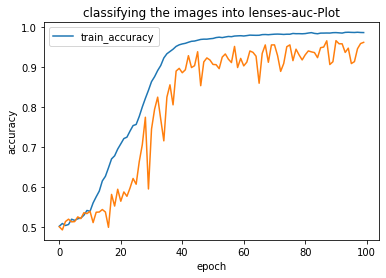

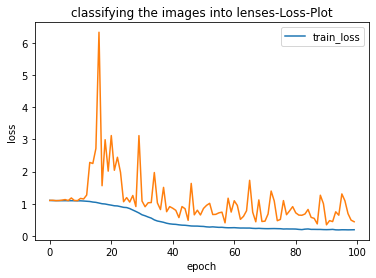

In [53]:
plot_accuracy(history,'classifying the images into lenses-auc-Plot')
plot_loss(history,'classifying the images into lenses-Loss-Plot')

In [65]:
y_true = np.argmax(Y_TEST, axis=1)
y_pred = np.argmax(model.predict(X_TEST), axis=1)

In [66]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2500
           1       0.82      0.84      0.83      2500
           2       0.91      0.87      0.89      2500

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500



In [67]:
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Confusion Matrix:
[[2221  226   53]
 [ 247 2102  151]
 [  78  238 2184]]


In [ ]:
# Confusion Matrix visualization
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

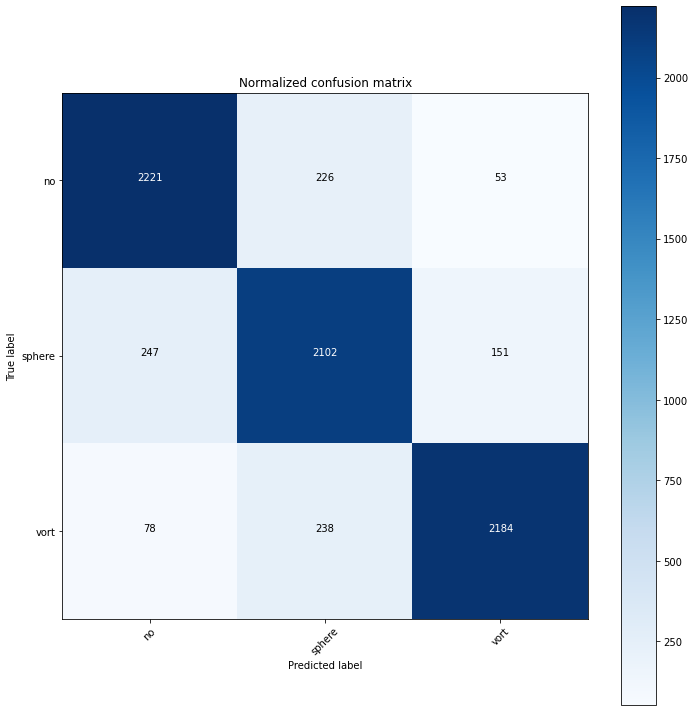

In [77]:
# Plot  confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=['no', 'sphere', 'vort'], normalize=False, title='Normalized confusion matrix')
display()

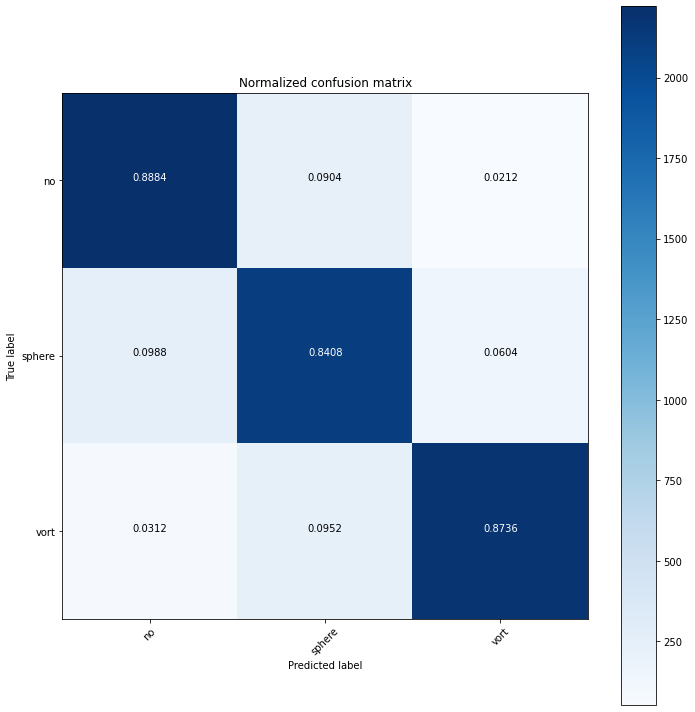

In [78]:
# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=['no', 'sphere', 'vort'], normalize=True, title='Normalized confusion matrix')
display()

In [64]:
def compute_roc_curve_and_area(y_true, y_score, n_classes):
    y_true_binarized = label_binarize(y_true, classes=range(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

# Example usage
y_true = np.argmax(Y_TEST, axis=1)
y_score = model.predict(X_TEST)
n_classes = 3

fpr, tpr, roc_auc = compute_roc_curve_and_area(y_true, y_score, n_classes)

for i in range(n_classes):
    print(f"Class {i}:")
    print(f"  FPR: {fpr[i]}")
    print(f"  TPR: {tpr[i]}")
    print(f"  ROC area: {roc_auc[i]}")


Class 0:
  FPR: [0.000e+00 0.000e+00 0.000e+00 2.000e-04 2.000e-04 4.000e-04 4.000e-04
 6.000e-04 6.000e-04 8.000e-04 8.000e-04 1.000e-03 1.000e-03 1.200e-03
 1.200e-03 1.200e-03 1.200e-03 1.200e-03 1.200e-03 1.400e-03 1.400e-03
 1.600e-03 1.600e-03 1.800e-03 1.800e-03 2.000e-03 2.000e-03 2.200e-03
 2.200e-03 2.400e-03 2.400e-03 2.600e-03 2.600e-03 2.800e-03 2.800e-03
 3.000e-03 3.000e-03 3.200e-03 3.200e-03 3.400e-03 3.400e-03 3.600e-03
 3.600e-03 3.800e-03 3.800e-03 4.000e-03 4.000e-03 4.200e-03 4.200e-03
 4.400e-03 4.400e-03 4.800e-03 4.800e-03 5.000e-03 5.000e-03 5.200e-03
 5.200e-03 5.400e-03 5.400e-03 5.600e-03 5.600e-03 5.800e-03 5.800e-03
 6.000e-03 6.000e-03 6.200e-03 6.200e-03 6.400e-03 6.400e-03 6.600e-03
 6.600e-03 6.800e-03 6.800e-03 7.000e-03 7.000e-03 7.200e-03 7.200e-03
 7.400e-03 7.400e-03 7.600e-03 7.600e-03 8.000e-03 8.000e-03 8.200e-03
 8.200e-03 8.400e-03 8.400e-03 8.600e-03 8.600e-03 8.800e-03 8.800e-03
 9.000e-03 9.000e-03 9.200e-03 9.200e-03 9.600e-03 9.600e-03 

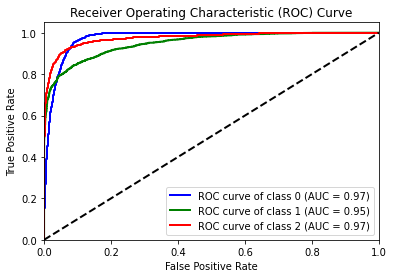

In [74]:
# ROC Curve visualization
def plot_roc_curve(fpr, tpr, roc_auc, n_classes):
    colors = ['blue', 'green', 'red']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(fpr, tpr, roc_auc, n_classes)

# save the model

In [79]:
# # save model
SAVE_MODEL_PATH = os.path.join(OUTPATH, 'model') # For storing model 
SAVE_MODEL_WEIGHTS_PATH = os.path.join(OUTPATH, 'model_weights') # For storing model weights

In [85]:
os.makedirs(SAVE_MODEL_PATH)
os.makedirs(SAVE_MODEL_WEIGHTS_PATH)

In [86]:
model.save(SAVE_MODEL_PATH+'\LensNet.hdf5')
model.save_weights(SAVE_MODEL_WEIGHTS_PATH+'\LensNet_weights.hdf5')